## This notebook is an exploration of the Kaggle Facial Keypoints Recognition Challenge dataset and a couple recommended models for solving it with machine learning

### This work is done as preliminary exploration for UT Bootcamp Team EPIC Project 3

In [42]:
#Dependenciesi
mport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.layers import Dropout, Flatten

In [3]:
facesDF = pd.read_csv('data/training.csv')

In [4]:
facesDF.head(10)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
5,69.680748,39.968748,29.183551,37.563364,62.864299,40.169271,76.898243,41.171888,36.401047,39.367626,...,58.800000,64.869084,82.471178,31.990430,81.669084,49.308112,78.487626,49.432374,93.898766,167 169 170 167 156 145 106 68 52 24 20 15 21 ...
6,64.131866,34.290040,29.578953,33.138040,57.797154,35.154040,69.026577,34.290040,34.761664,33.714040,...,53.006174,55.781799,70.570953,33.898309,70.282953,45.127732,65.099597,45.415732,78.057020,109 109 125 141 145 139 120 81 45 34 31 35 36 ...
7,67.468893,39.413452,29.355961,39.621717,59.554951,40.454773,75.591612,40.038245,37.478214,40.454773,...,56.907961,66.843961,80.025786,30.189204,81.275184,48.100194,71.278602,48.516816,91.063922,178 177 178 179 179 179 181 185 188 184 192 20...
8,65.802880,34.755200,27.475840,36.185600,58.652160,37.329280,72.952960,35.899520,36.342400,37.043200,...,55.348480,65.516800,73.368320,31.194240,74.798080,49.213440,67.648000,49.499520,83.093120,164 158 118 76 66 69 59 53 43 31 35 41 45 55 6...
9,64.121231,36.740308,29.468923,38.390154,58.620923,37.840615,71.272000,37.290338,36.344615,39.490462,...,54.341538,65.771692,69.192615,32.769231,72.217846,49.270154,67.542769,49.545231,76.893538,226 227 225 224 221 220 215 210 210 208 206 18...


In [5]:
facesDF.shape

(7049, 31)

In [43]:
def string2array(string):
    """Converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

def plot_faces(nrows=5, ncols=5):
    """Randomly displays some faces from the training data."""
    selection = np.random.choice(facesDF.index, size=(nrows*ncols), replace=False)
    image_strings = facesDF.loc[selection]['Image']
    fig, axes = plt.subplots(figsize=(15, 15), nrows=nrows, ncols=ncols)
    for string, ax in zip(image_strings, axes.ravel()):
        ax.imshow(string2array(string), cmap='gray')
        ax.axis('off')

### The majority of images in the data set are facing forward and reasonably clear. There are a number of images that are skewed, low resolution and blurry which should present an additional challenge for training.

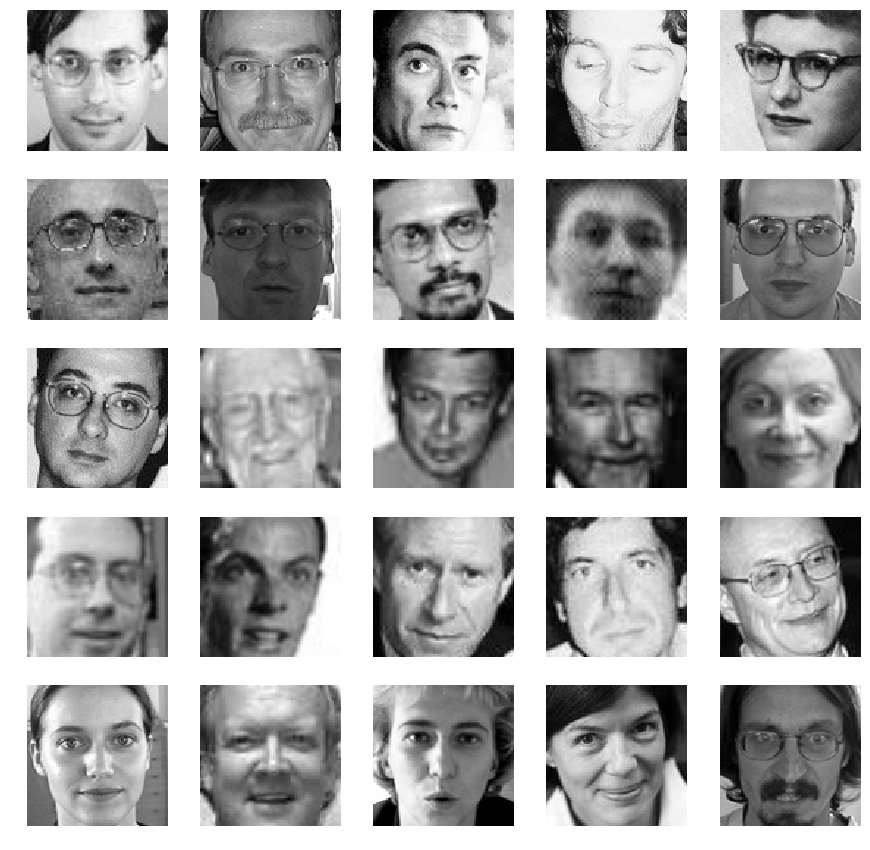

In [44]:
plot_faces()

In [8]:

def plot_faces_with_keypoints(nrows=5, ncols=5):
    """Randomly displays some faces from the training data with their keypoints."""
    selection = np.random.choice(facesDF.index, size=(nrows*ncols), replace=False)
    image_strings = facesDF.loc[selection]['Image']
    keypoint_cols = list(facesDF.columns)[:-1]
    keypoints = facesDF.loc[selection][keypoint_cols]
    fig, axes = plt.subplots(figsize=(15, 15), nrows=nrows, ncols=ncols)
    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((15, 2))
        ax.imshow(string2array(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'ro')
        ax.axis('off')

### Many of the faces have 15 keypoints identified as would be indicated by the structure of the dataset. However, depending on the sample that you see below, you will likely see many that have a subset of keypoints identified. Also note that the placement of the'nose tip' point varies somewhat from the point of the nose to hanging just below the tip of the nose. Quite a few seem to mark the philtrum. This may cause the model to position it low in its predictions.

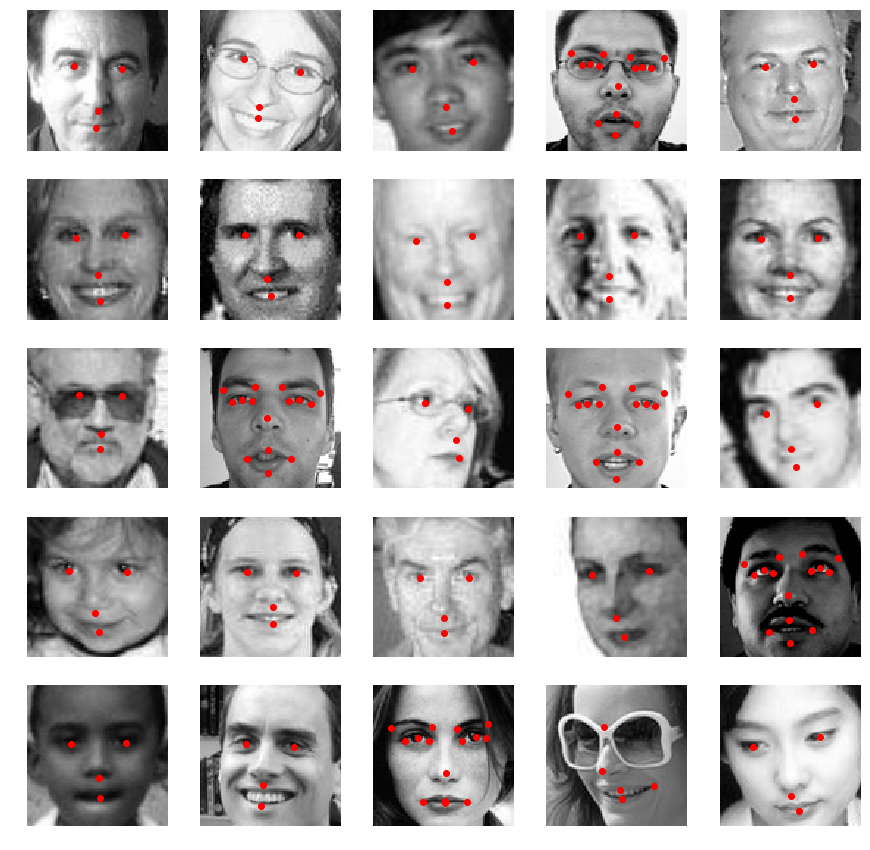

In [9]:
plot_faces_with_keypoints()

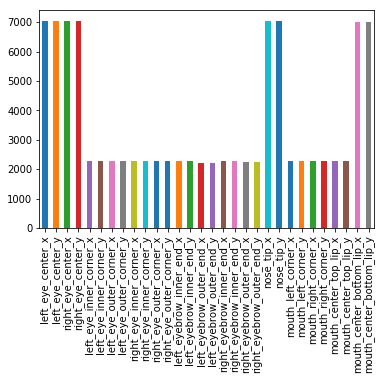

In [10]:
facesDF.describe().loc['count'].plot.bar()

### From the plot above its clear that only about 2000 faces have 15 keypoints identified. About 5000 only have eye centers, nose tip, and center of bottom lip. Dropping out the zero entries we have 2140 faces with all points identified.

### I'm going to try runnning the model on just the 2140 to make 30 keypoint predictions. Then I will run the model with the entire set but only ask it to predict the 4 points.

In [11]:
twoKGoodFaces = facesDF.dropna()

In [12]:
twoKGoodFaces.shape

(2140, 31)

# Building the model for 2140 "GoodFaces" with 15 data points

In [47]:
#making data and target arrays
X15 = np.stack([string2array(string) for string in twoKGoodFaces['Image']]).astype(np.float)[:, :, :, np.newaxis]
y15 = np.vstack(twoKGoodFaces[twoKGoodFaces.columns[:-1]].values)
print(X15.shape, X15.dtype)
print(y15.shape, y15.dtype)

(2140, 96, 96, 1) float64
(2140, 30) float64


In [48]:
#converting datapoints to 0 -1 values
X15_train = X15/255.

In [49]:
# Creating pipeline
output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y15_train = output_pipe.fit_transform(y15)

In [71]:
y15_train.shape

(2140, 30)

In [50]:
# defining the keras model
model15 = Sequential()
model15.add(Dense(100, activation="relu", input_shape=(96*96,)))
model15.add(Activation('relu'))
model15.add(Dense(30))

In [51]:
# compile and run the model
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model15.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 200
history = model15.fit(X15_train.reshape(y15_train.shape[0], -1), y15_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 1712 samples, validate on 428 samples
Epoch 1/200
1712/1712 [==============================] - 1s 536us/step - loss: 0.0545 - acc: 0.1390 - val_loss: 0.0707 - val_acc: 0.0514
Epoch 2/200
1712/1712 [==============================] - 1s 473us/step - loss: 0.0352 - acc: 0.3183 - val_loss: 0.0699 - val_acc: 0.0584
Epoch 3/200
1712/1712 [==============================] - 1s 484us/step - loss: 0.0333 - acc: 0.3440 - val_loss: 0.0680 - val_acc: 0.0491
Epoch 4/200
1712/1712 [==============================] - 1s 454us/step - loss: 0.0323 - acc: 0.3598 - val_loss: 0.0667 - val_acc: 0.0374
Epoch 5/200
1712/1712 [==============================] - 1s 453us/step - loss: 0.0311 - acc: 0.3721 - val_loss: 0.0657 - val_acc: 0.0444
Epoch 6/200
1712/1712 [==============================] - 1s 459us/step - loss: 0.0300 - acc: 0.3797 - val_loss: 0.0648 - val_acc: 0.0491
Epoch 7/200
1712/1712 [==============================] - 1s 462us/step - loss: 0.0290 - acc: 0.3785 - val_loss: 0.0652 - val_acc: 0

1712/1712 [==============================] - 1s 457us/step - loss: 0.0121 - acc: 0.5164 - val_loss: 0.0524 - val_acc: 0.1402
Epoch 61/200
1712/1712 [==============================] - 1s 460us/step - loss: 0.0125 - acc: 0.5187 - val_loss: 0.0495 - val_acc: 0.1402
Epoch 62/200
1712/1712 [==============================] - 1s 463us/step - loss: 0.0125 - acc: 0.5093 - val_loss: 0.0485 - val_acc: 0.1262
Epoch 63/200
1712/1712 [==============================] - 1s 458us/step - loss: 0.0121 - acc: 0.5129 - val_loss: 0.0486 - val_acc: 0.1379
Epoch 64/200
1712/1712 [==============================] - 1s 473us/step - loss: 0.0124 - acc: 0.5076 - val_loss: 0.0493 - val_acc: 0.1192
Epoch 65/200
1712/1712 [==============================] - 1s 466us/step - loss: 0.0121 - acc: 0.5263 - val_loss: 0.0488 - val_acc: 0.1238
Epoch 66/200
1712/1712 [==============================] - 1s 465us/step - loss: 0.0118 - acc: 0.5140 - val_loss: 0.0486 - val_acc: 0.1425
Epoch 67/200
1712/1712 [=======================

1712/1712 [==============================] - 1s 461us/step - loss: 0.0079 - acc: 0.5572 - val_loss: 0.0494 - val_acc: 0.1636
Epoch 179/200
1712/1712 [==============================] - 1s 458us/step - loss: 0.0078 - acc: 0.5415 - val_loss: 0.0488 - val_acc: 0.1542
Epoch 180/200
1712/1712 [==============================] - 1s 460us/step - loss: 0.0078 - acc: 0.5450 - val_loss: 0.0510 - val_acc: 0.1565
Epoch 181/200
1712/1712 [==============================] - 1s 479us/step - loss: 0.0078 - acc: 0.5549 - val_loss: 0.0515 - val_acc: 0.1425
Epoch 182/200
1712/1712 [==============================] - 1s 508us/step - loss: 0.0080 - acc: 0.5467 - val_loss: 0.0496 - val_acc: 0.1589
Epoch 183/200
1712/1712 [==============================] - 1s 456us/step - loss: 0.0078 - acc: 0.5607 - val_loss: 0.0488 - val_acc: 0.1589
Epoch 184/200
1712/1712 [==============================] - 1s 461us/step - loss: 0.0078 - acc: 0.5567 - val_loss: 0.0498 - val_acc: 0.1308
Epoch 185/200
1712/1712 [================

### The model above takes about 3 minutes to run. It does okay on accuracy (almost .6) with the training set but there is some overfitting occuring because it only approaches .2  on the validation images. But how this is measured is not clear. See the images below for a qualitiative look at accuracy.


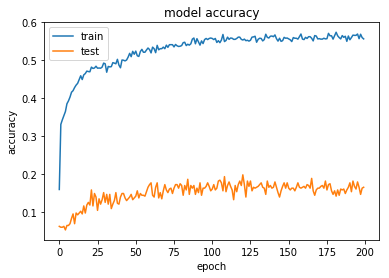

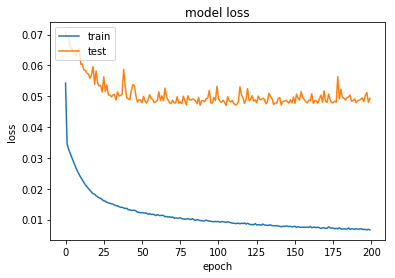

In [19]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
def plot_faces_with_keypoints_and_predictions(model15, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X15.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(15, 15), nrows=nrows, ncols=ncols)

    for ind, ax in zip(selection, axes.ravel()):
        img = X15_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model15.predict(img.reshape(1, -1))
        else:
            predictions = model15.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'ro')
        ax.axis('off')
        
    image_strings = facesDF.loc[selection]['Image']
    keypoint_cols = list(facesDF.columns)[:-1]
    keypoints = facesDF.loc[selection][keypoint_cols]

    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((15, 2))
        ax.imshow(string2array(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'go')
        ax.axis('off')
        


### The images below are a random sampling of the test images with the provided training keypoints added in green and the model predicted keypoints in red. It does okay with standard poses but much of an angle or unusual expression and the results are not so good. Perhaps good enough for accessory image placement, but we should see if we can improve the accuracy.

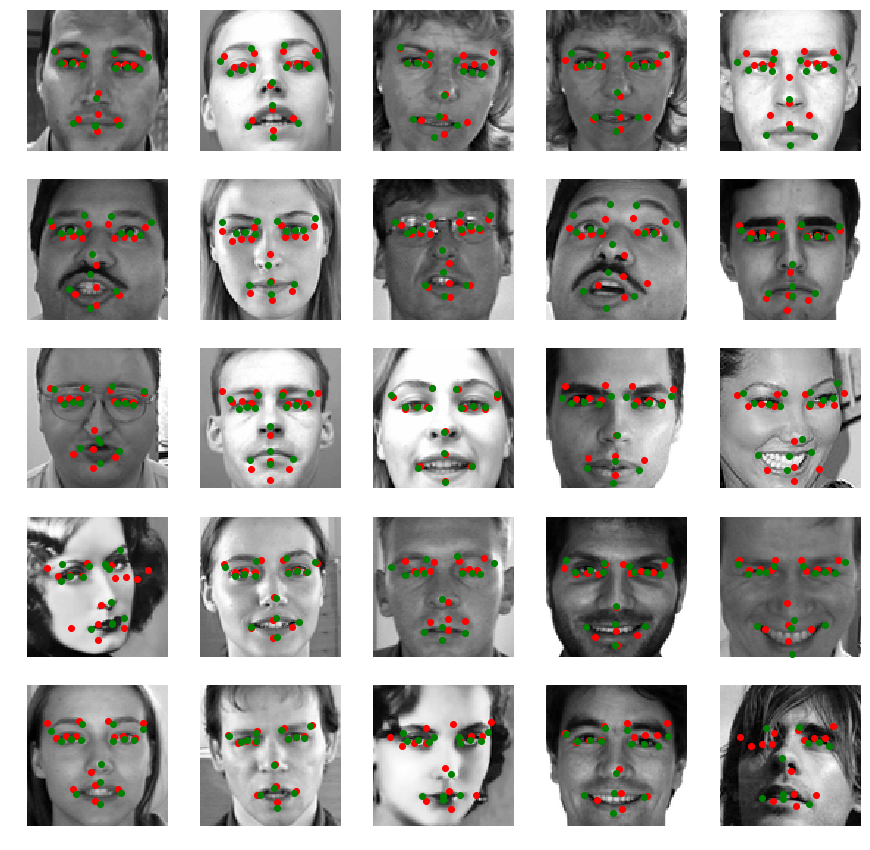

In [41]:
# calling the function above to plot the faces with the training pointss shown in green and the predicted points for hte same image shown in red
plot_faces_with_keypoints_and_predictions(model15)

### Now I will try the same model will all 7094 faces but only ask the model to find 4 points.

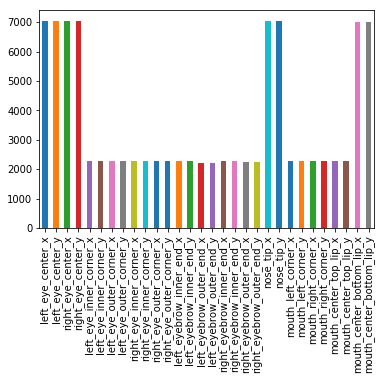

In [53]:
facesDF.describe().loc['count'].plot.bar()

In [54]:
sevenKSimpleFaces= facesDF[['left_eye_center_x','left_eye_center_y','right_eye_center_x','right_eye_center_y','nose_tip_x','nose_tip_y','mouth_center_bottom_lip_x','mouth_center_bottom_lip_y','Image']]

In [56]:
sevenKSimpleFaces.shape
# There are 9 data columns becasue there are two coordinates for each point and one column for the image data

(7049, 9)

In [57]:
sevenKSimpleFaces = sevenKSimpleFaces.dropna()

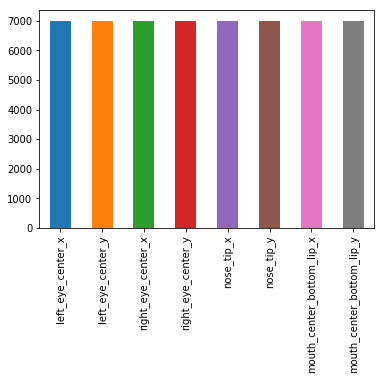

In [58]:
sevenKSimpleFaces.describe().loc['count'].plot.bar()

In [59]:
X4 = np.stack([string2array(string) for string in sevenKSimpleFaces['Image']]).astype(np.float)[:, :, :, np.newaxis]
y4 = np.vstack(sevenKSimpleFaces[sevenKSimpleFaces.columns[:-1]].values)
print(X4.shape, X4.dtype)
print(y4.shape, y4.dtype)

(7000, 96, 96, 1) float64
(7000, 8) float64


In [60]:
#converting datapoints to 0 -1 values
X4_train = X4/255.


In [61]:
# Creating pipeline
output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y4_train = output_pipe.fit_transform(y4)

In [62]:
# defining the keras model
model4 = Sequential()
model4.add(Dense(100, activation="relu", input_shape=(96*96,)))
model4.add(Activation('relu'))
model4.add(Dense(8))

In [63]:
# compile and run the model
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model4.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 200
history = model4.fit(X4_train.reshape(y4_train.shape[0], -1), y4_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 5600 samples, validate on 1400 samples
Epoch 1/200
5600/5600 [==============================] - 3s 517us/step - loss: 0.0598 - acc: 0.9366 - val_loss: 0.0125 - val_acc: 0.9807
Epoch 2/200
5600/5600 [==============================] - 3s 460us/step - loss: 0.0121 - acc: 0.9584 - val_loss: 0.0125 - val_acc: 0.9807
Epoch 3/200
5600/5600 [==============================] - 3s 466us/step - loss: 0.0116 - acc: 0.9584 - val_loss: 0.0123 - val_acc: 0.9807
Epoch 4/200
5600/5600 [==============================] - 3s 458us/step - loss: 0.0113 - acc: 0.9584 - val_loss: 0.0115 - val_acc: 0.9800
Epoch 5/200
5600/5600 [==============================] - 3s 470us/step - loss: 0.0111 - acc: 0.9580 - val_loss: 0.0112 - val_acc: 0.9793
Epoch 6/200
5600/5600 [==============================] - 3s 469us/step - loss: 0.0109 - acc: 0.9577 - val_loss: 0.0114 - val_acc: 0.9793
Epoch 7/200
5600/5600 [==============================] - 3s 463us/step - loss: 0.0106 - acc: 0.9573 - val_loss: 0.0110 - val_acc: 

5600/5600 [==============================] - 3s 461us/step - loss: 0.0060 - acc: 0.9521 - val_loss: 0.0096 - val_acc: 0.9664
Epoch 61/200
5600/5600 [==============================] - 3s 451us/step - loss: 0.0060 - acc: 0.9525 - val_loss: 0.0084 - val_acc: 0.9636
Epoch 62/200
5600/5600 [==============================] - 3s 452us/step - loss: 0.0059 - acc: 0.9523 - val_loss: 0.0084 - val_acc: 0.9579
Epoch 63/200
5600/5600 [==============================] - 3s 452us/step - loss: 0.0059 - acc: 0.9523 - val_loss: 0.0084 - val_acc: 0.9600
Epoch 64/200
5600/5600 [==============================] - 3s 457us/step - loss: 0.0059 - acc: 0.9537 - val_loss: 0.0088 - val_acc: 0.9629
Epoch 65/200
5600/5600 [==============================] - 3s 457us/step - loss: 0.0059 - acc: 0.9529 - val_loss: 0.0084 - val_acc: 0.9443
Epoch 66/200
5600/5600 [==============================] - 3s 456us/step - loss: 0.0059 - acc: 0.9527 - val_loss: 0.0094 - val_acc: 0.9707
Epoch 67/200
5600/5600 [=======================

5600/5600 [==============================] - 2s 442us/step - loss: 0.0048 - acc: 0.9586 - val_loss: 0.0089 - val_acc: 0.9793
Epoch 179/200
5600/5600 [==============================] - 2s 442us/step - loss: 0.0048 - acc: 0.9587 - val_loss: 0.0082 - val_acc: 0.9786
Epoch 180/200
5600/5600 [==============================] - 2s 442us/step - loss: 0.0048 - acc: 0.9582 - val_loss: 0.0083 - val_acc: 0.9793
Epoch 181/200
5600/5600 [==============================] - 2s 445us/step - loss: 0.0048 - acc: 0.9587 - val_loss: 0.0086 - val_acc: 0.9793
Epoch 182/200
5600/5600 [==============================] - 2s 444us/step - loss: 0.0048 - acc: 0.9586 - val_loss: 0.0089 - val_acc: 0.9793
Epoch 183/200
5600/5600 [==============================] - 2s 443us/step - loss: 0.0048 - acc: 0.9587 - val_loss: 0.0090 - val_acc: 0.9793
Epoch 184/200
5600/5600 [==============================] - 2s 443us/step - loss: 0.0048 - acc: 0.9586 - val_loss: 0.0091 - val_acc: 0.9779
Epoch 185/200
5600/5600 [================

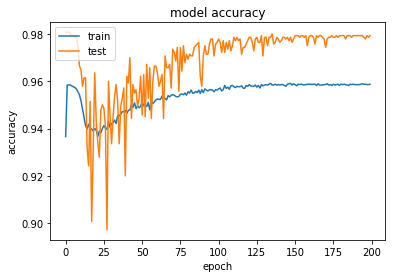

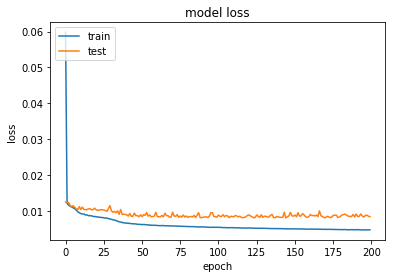

In [64]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [86]:
def plot_faces_with_4keypoints_and_predictions(model4, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X4.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(15, 15), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X4_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model4.predict(img.reshape(1, -1))
#             print("flat")
        else:
            predictions = model4.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(4, 2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'ro')
        ax.axis('off')
#         print(xy_predictions[:, 0], xy_predictions[:, 1])


        
    image_strings = sevenKSimpleFaces.loc[selection]['Image']
    keypoint_cols = list(sevenKSimpleFaces.columns)[:-1]
    keypoints = sevenKSimpleFaces.loc[selection][keypoint_cols]

    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((4, 2))
        ax.imshow(string2array(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'go')
        ax.axis('off')
        

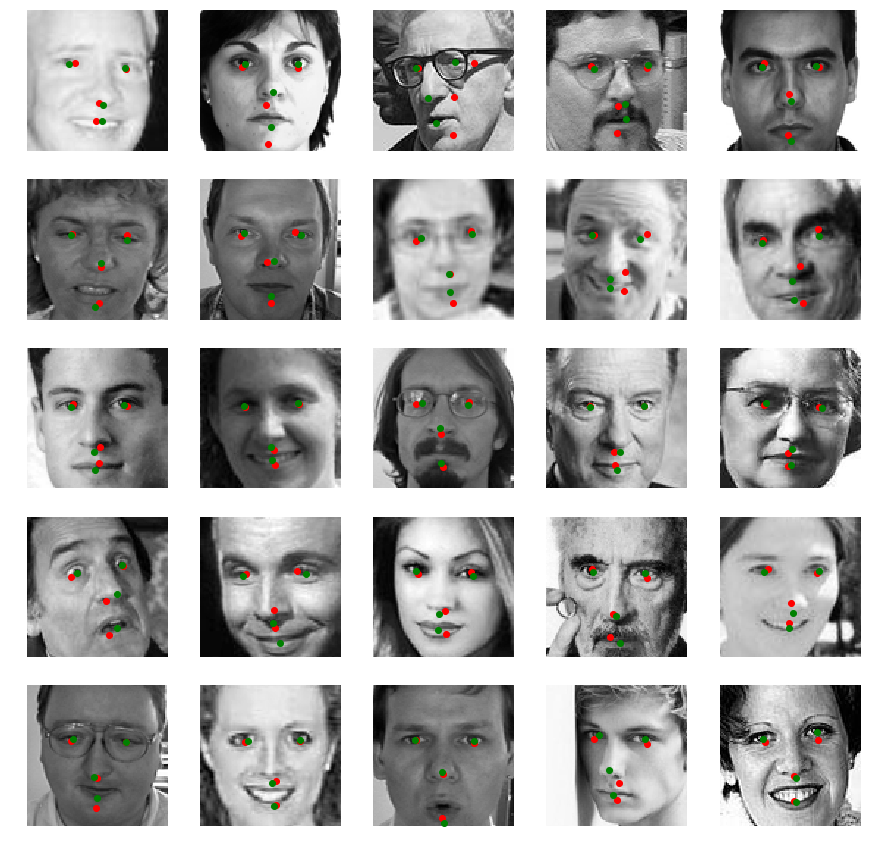

In [90]:
plot_faces_with_4keypoints_and_predictions(model4)